In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from collections import OrderedDict
from sklearn.preprocessing import (MinMaxScaler, Normalizer, StandardScaler, RobustScaler)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, Dense
from keras.utils import plot_model

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
start_time = time.time()

## FUNCTIONS

In [3]:
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

local pc

In [4]:
#ds = ".\\DS\\out\\df_10000.csv"
#df = pd.read_csv(ds)
##df = df.drop(df.columns[0] ,axis=1,inplace=False)

google colab

In [5]:
ds = "/content/drive/My Drive/THESIS/Notebook/df_50000.csv"
df = pd.read_csv(ds)

In [6]:
df.head(3)

Destination Port  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0             60353        8748757                  1                       5   
1             57317             39                  3                       0   
2                80      112166755                 20                      16   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                            6                           30   
1                           43                            0   
2                         1748                         3184   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                      6                      6                6.000000   
1                     31                      6               14.333333   
2                    437                      0               87.400000   

   Fwd Packet Length Std  ...  min_seg_size_forward  Active Mean   Active Std  \
0               0.000000  ...                    20      27997.0        0.000   
1              14.433757  ...                    20          0.0        0.000   
2             179.341016  ...                    32    1005330.2  3095465.454   

   Active Max  Active Min   Idle Mean     Idle Std  Idle Max  Idle Min   Label  
0       27997       27997   8720760.0      0.00000   8720760   8720760  BENIGN  
1           0           0         0.0      0.00000         0         0  BENIGN  
2     9815152       23665  10200000.0  19960.18934  10200000  10200000  BENIGN  

[3 rows x 79 columns]

In [7]:
df.shape

(50000, 79)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 79 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Destination Port             50000 non-null  int64  
 1   Flow Duration                50000 non-null  int64  
 2   Total Fwd Packets            50000 non-null  int64  
 3   Total Backward Packets       50000 non-null  int64  
 4   Total Length of Fwd Packets  50000 non-null  int64  
 5   Total Length of Bwd Packets  50000 non-null  int64  
 6   Fwd Packet Length Max        50000 non-null  int64  
 7   Fwd Packet Length Min        50000 non-null  int64  
 8   Fwd Packet Length Mean       50000 non-null  float64
 9   Fwd Packet Length Std        50000 non-null  float64
 10  Bwd Packet Length Max        50000 non-null  int64  
 11  Bwd Packet Length Min        50000 non-null  int64  
 12  Bwd Packet Length Mean       50000 non-null  float64
 13  Bwd Packet Lengt

In [9]:
df.describe().T

count          mean           std  min    25%  \
Destination Port             50000.0  7.971869e+03  1.819003e+04  0.0   53.0   
Flow Duration                50000.0  1.491557e+07  3.377647e+07 -1.0  156.0   
Total Fwd Packets            50000.0  1.408340e+01  1.261433e+03  1.0    2.0   
Total Backward Packets       50000.0  1.678618e+01  1.708781e+03  0.0    1.0   
Total Length of Fwd Packets  50000.0  5.712896e+02  8.350509e+03  0.0   12.0   
...                              ...           ...           ...  ...    ...   
Active Min                   50000.0  5.861301e+04  5.700910e+05  0.0    0.0   
Idle Mean                    50000.0  8.330855e+06  2.364075e+07  0.0    0.0   
Idle Std                     50000.0  5.056398e+05  4.582837e+06  0.0    0.0   
Idle Max                     50000.0  8.709202e+06  2.436988e+07  0.0    0.0   
Idle Min                     50000.0  7.933477e+06  2.337322e+07  0.0    0.0   

                                 50%         75%          max  
Destination Port                80.0      443.00      65529.0  
Flow Duration                31257.5  3602438.75  119999910.0  
Total Fwd Packets                2.0        5.00     207964.0  
Total Backward Packets           2.0        4.00     284602.0  
Total Length of Fwd Packets     62.0      187.00    1235152.0  
...                              ...         ...          ...  
Active Min                       0.0        0.00   70100000.0  
Idle Mean                        0.0        0.00  120000000.0  
Idle Std                         0.0        0.00   70200000.0  
Idle Max                         0.0        0.00  120000000.0  
Idle Min                         0.0        0.00  120000000.0  

[78 rows x 8 columns]

In [10]:
# Discarding NA values.
# Replace infinite updated data with nan
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN
df.dropna(inplace=True)
df.shape

(49964, 79)

In [11]:
is_inf = df.isin([np.inf, -np.inf]).any()
is_inf[is_inf]

Series([], dtype: bool)

## feature selection phase - find cols with all zero values

In [12]:
#all_datav2.describe().iloc[1:].apply(np.sum, index=[])
describe_info = df.describe()
all_zeroes_cols = describe_info.loc[:,(describe_info.iloc[1:] == 0).all()]
all_zeroes_cols

Bwd PSH Flags  Bwd URG Flags  Fwd Avg Bytes/Bulk  Fwd Avg Packets/Bulk  \
count        49964.0        49964.0             49964.0               49964.0   
mean             0.0            0.0                 0.0                   0.0   
std              0.0            0.0                 0.0                   0.0   
min              0.0            0.0                 0.0                   0.0   
25%              0.0            0.0                 0.0                   0.0   
50%              0.0            0.0                 0.0                   0.0   
75%              0.0            0.0                 0.0                   0.0   
max              0.0            0.0                 0.0                   0.0   

       Fwd Avg Bulk Rate  Bwd Avg Bytes/Bulk  Bwd Avg Packets/Bulk  \
count            49964.0             49964.0               49964.0   
mean                 0.0                 0.0                   0.0   
std                  0.0                 0.0                   0.0   
min                  0.0                 0.0                   0.0   
25%                  0.0                 0.0                   0.0   
50%                  0.0                 0.0                   0.0   
75%                  0.0                 0.0                   0.0   
max                  0.0                 0.0                   0.0   

       Bwd Avg Bulk Rate  
count            49964.0  
mean                 0.0  
std                  0.0  
min                  0.0  
25%                  0.0  
50%                  0.0  
75%                  0.0  
max                  0.0

In [13]:
df.drop(columns=all_zeroes_cols, inplace=True)
df.shape

(49964, 71)

In [14]:
## Creates a  new column to distinguish if is either positive for attack or not.
is_attack = df.loc[:, "Label"].map(lambda lbl: 0 if lbl == "BENIGN" else 1)
is_attack.name = "is_attack"
df.loc[:, is_attack.name] = is_attack
df.shape

(49964, 72)

In [15]:
class_counts = df['is_attack'].value_counts()
xaxis_labels =["Normal","Attack"]
colors = {'Normal':'green','Attack':'red' }
legend_labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in legend_labels]
ymax = df.shape [0]
count_dict = class_counts.to_dict()
traffic_counts = count_dict.values()
#type(class_counts) # pandas.core.series.Series

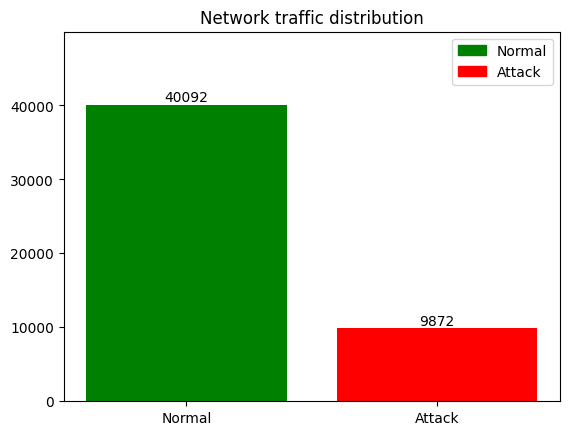

In [16]:
fig, ax = plt.subplots()
bar_container = ax.bar(xaxis_labels, traffic_counts,color =['green','red'])
ax.set(title='Network traffic distribution', ylim=(0, ymax))
ax.bar_label(bar_container, fmt=lambda x: f'{x:.0f}')
ax.legend(handles=handles, labels=legend_labels)

plt.show()

## DOWNSAMPLING

In [17]:
df.loc[:, "is_attack"].value_counts()
rus = RandomUnderSampler(random_state=10, sampling_strategy=0.85) # equals traffic unless ratio is specified
df.drop(["is_attack"], axis=1, inplace=True) # temporarily rm the categorical column for underSampling
all_data_res, trf_type_res = rus.fit_resample(df, is_attack)
#all_datav2 = pd.concat([all_data_res, trf_type_res], join="inner")  # another way to join dataframe w/ series
all_datav2 = all_data_res.join(trf_type_res, how="inner")
all_datav2.shape # check if resulting DaraFrame valid

(21486, 72)

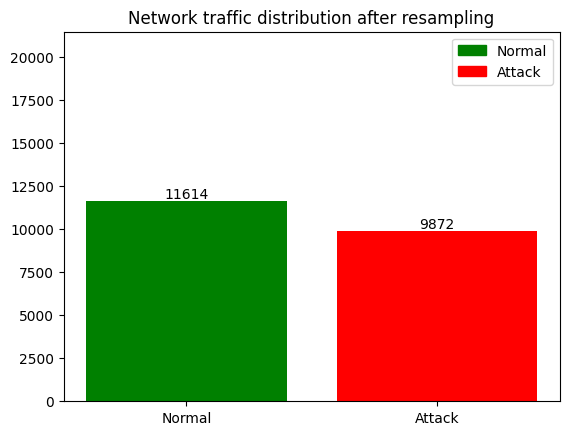

In [18]:
class_counts = all_datav2['is_attack'].value_counts()
xaxis_labels =["Normal","Attack"]
colors = {'Normal':'green','Attack':'red' }
legend_labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in legend_labels]
ymax = all_datav2.shape [0]
count_dict = class_counts.to_dict()
traffic_counts = count_dict.values()

fig, ax = plt.subplots()
bar_container = ax.bar(xaxis_labels, traffic_counts,color =['green','red'])
ax.set(title='Network traffic distribution after resampling', ylim=(0, ymax))
ax.bar_label(bar_container, fmt=lambda x: f'{x:.0f}')
ax.legend(handles=handles, labels=legend_labels)

plt.show()

In [19]:
all_datav2.dropna()
#all_datav2.info()

Destination Port  Flow Duration  Total Fwd Packets  \
11564                80          82137                  3   
38615                80       60109683                  5   
6991                 53       97240359                  3   
44163               443          90639                  6   
47255                53          62141                  2   
...                 ...            ...                ...   
49972              2046             48                  1   
49975              1047             39                  1   
49976                80         589431                  3   
49983                80          16012                  2   
49995                80          59317                  3   

       Total Backward Packets  Total Length of Fwd Packets  \
11564                       4                          443   
38615                       3                          195   
6991                        3                          167   
44163                       8                         1106   
47255                       2                           76   
...                       ...                          ...   
49972                       1                            0   
49975                       1                            2   
49976                       4                           26   
49983                       2                           12   
49995                       6                          300   

       Total Length of Bwd Packets  Fwd Packet Length Max  \
11564                          872                    437   
38615                         1703                    195   
6991                           433                     64   
44163                          538                    821   
47255                          288                     38   
...                            ...                    ...   
49972                            6                      0   
49975                            6                      2   
49976                        11607                     20   
49983                            0                      6   
49995                        11595                    300   

       Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  \
11564                      0              147.666667             250.587975   
38615                      0               39.000000              87.206651   
6991                      43               55.666667              11.150486   
44163                      0              184.333333             322.457232   
47255                     38               38.000000               0.000000   
...                      ...                     ...                    ...   
49972                      0                0.000000               0.000000   
49975                      2                2.000000               0.000000   
49976                      0                8.666667              10.263203   
49983                      6                6.000000               0.000000   
49995                      0              100.000000             173.205081   

       ...  Active Mean   Active Std  Active Max  Active Min   Idle Mean  \
11564  ...          0.0     0.000000           0           0         0.0   
38615  ...          0.0     0.000000           0           0         0.0   
6991   ...      65165.5  3261.883582       67472       62859  48500000.0   
44163  ...          0.0     0.000000           0           0         0.0   
47255  ...          0.0     0.000000           0           0         0.0   
...    ...          ...          ...         ...         ...         ...   
49972  ...          0.0     0.000000           0           0         0.0   
49975  ...          0.0     0.000000           0           0         0.0   
49976  ...          0.0     0.000000           0           0         0.0   
49983  ...          0.0     0.000000           0           0         0.0   
49995  ... 

## CALCULATING FEATURES' IMPORTANCE

In [20]:
## feature selection phase - prepare data for RFC
#lbls = all_datav2.loc[:, "Label"]
data_w_o_cat_attrs = all_datav2.iloc[:, :-2]
#lbls
data_w_o_cat_attrs

Destination Port  Flow Duration  Total Fwd Packets  \
11564                80          82137                  3   
38615                80       60109683                  5   
6991                 53       97240359                  3   
44163               443          90639                  6   
47255                53          62141                  2   
...                 ...            ...                ...   
49972              2046             48                  1   
49975              1047             39                  1   
49976                80         589431                  3   
49983                80          16012                  2   
49995                80          59317                  3   

       Total Backward Packets  Total Length of Fwd Packets  \
11564                       4                          443   
38615                       3                          195   
6991                        3                          167   
44163                       8                         1106   
47255                       2                           76   
...                       ...                          ...   
49972                       1                            0   
49975                       1                            2   
49976                       4                           26   
49983                       2                           12   
49995                       6                          300   

       Total Length of Bwd Packets  Fwd Packet Length Max  \
11564                          872                    437   
38615                         1703                    195   
6991                           433                     64   
44163                          538                    821   
47255                          288                     38   
...                            ...                    ...   
49972                            6                      0   
49975                            6                      2   
49976                        11607                     20   
49983                            0                      6   
49995                        11595                    300   

       Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  \
11564                      0              147.666667             250.587975   
38615                      0               39.000000              87.206651   
6991                      43               55.666667              11.150486   
44163                      0              184.333333             322.457232   
47255                     38               38.000000               0.000000   
...                      ...                     ...                    ...   
49972                      0                0.000000               0.000000   
49975                      2                2.000000               0.000000   
49976                      0                8.666667              10.263203   
49983                      6                6.000000               0.000000   
49995                      0              100.000000             173.205081   

       ...  act_data_pkt_fwd  min_seg_size_forward  Active Mean   Active Std  \
11564  ...                 2                    20          0.0     0.000000   
38615  ...                 1                    20          0.0     0.000000   
6991   ...                 2                    32      65165.5  3261.883582   
44163  ...                 3                    32          0.0     0.000000   
47255  ...                 1                    20          0.0     0.000000   
...    ...               ...                   ...          ...          ...   
49972  ...                 0                    40          0.0     0.000000   
49975  ...                 0                    24          0.0     0.000000   
49976  ...                 2                    20          0.0     0.000000   
49983  ...                 1                   

In [21]:
lbls = all_datav2.loc[:, "is_attack"]

In [22]:
rfc = RandomForestClassifier(random_state=10, n_jobs=1) # 100 trees in forest

# fit random forest classifier on the dataset
rfc.fit(data_w_o_cat_attrs, lbls)

RandomForestClassifier(n_jobs=1, random_state=10)

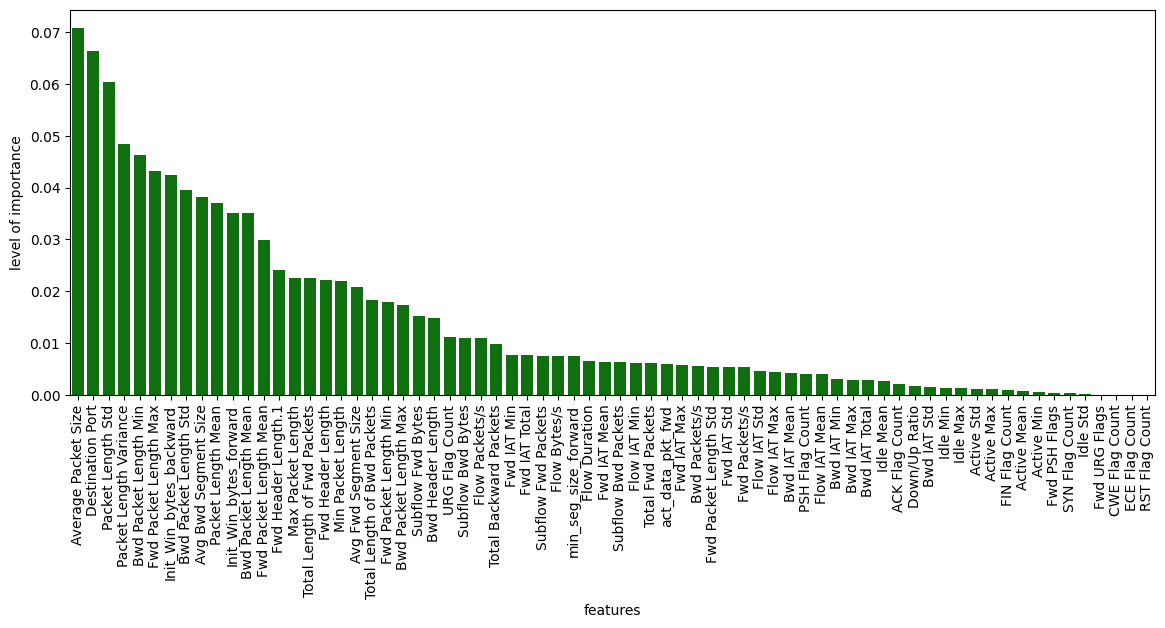

In [23]:
score = np.round(rfc.feature_importances_,5)
importances = pd.DataFrame({'features':data_w_o_cat_attrs.columns,'level of importance':score})
importances = importances.sort_values('level of importance',ascending=False).set_index('features')
# plot importances
sns.barplot(x=importances.index, y="level of importance", data=importances, color="green")
plt.xticks(rotation="vertical")
plt.gcf().set_size_inches(14,5)
#plt.savefig("importances.png", dpi=200, format='png', bbox_inches = "tight", pad_inches=0.2)
plt.show()

In [24]:
threshold = 0.001 # importance threshold
bl_thresh = importances.loc[importances["level of importance"] < threshold]
print("there are {} features to delete, as they are below chosen threshold".format(bl_thresh.shape[0]))
print("these features are the following:")
feats_to_del = [feat for feat in bl_thresh.index]
print("\n".join(feats_to_del))

there are 10 features to delete, as they are below chosen threshold
these features are the following:
FIN Flag Count
Active Mean
Active Min
Fwd PSH Flags
SYN Flag Count
Idle Std
Fwd URG Flags
CWE Flag Count
ECE Flag Count
RST Flag Count


In [25]:
## removing these not important features
all_datav2.drop(columns=feats_to_del, inplace=True)

In [26]:
all_datav2.head(3)

Destination Port  Flow Duration  Total Fwd Packets  \
11564                80          82137                  3   
38615                80       60109683                  5   
6991                 53       97240359                  3   

       Total Backward Packets  Total Length of Fwd Packets  \
11564                       4                          443   
38615                       3                          195   
6991                        3                          167   

       Total Length of Bwd Packets  Fwd Packet Length Max  \
11564                          872                    437   
38615                         1703                    195   
6991                           433                     64   

       Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  \
11564                      0              147.666667             250.587975   
38615                      0               39.000000              87.206651   
6991                      43               55.666667              11.150486   

       ...  Init_Win_bytes_backward  act_data_pkt_fwd  min_seg_size_forward  \
11564  ...                       31                 2                    20   
38615  ...                      946                 1                    20   
6991   ...                       -1                 2                    32   

        Active Std  Active Max   Idle Mean  Idle Max  Idle Min   Label  \
11564     0.000000           0         0.0         0         0  BENIGN   
38615     0.000000           0         0.0         0         0  BENIGN   
6991   3261.883582       67472  48500000.0  77800000  19200000  BENIGN   

       is_attack  
11564          0  
38615          0  
6991           0  

[3 rows x 62 columns]

DETECTING HIGHLY CORRELATED FEATURES

In [27]:
all_datav2 = all_datav2.drop(columns =["Label"]).copy()
#all_datav2
all_datav2.head(3)

Destination Port  Flow Duration  Total Fwd Packets  \
11564                80          82137                  3   
38615                80       60109683                  5   
6991                 53       97240359                  3   

       Total Backward Packets  Total Length of Fwd Packets  \
11564                       4                          443   
38615                       3                          195   
6991                        3                          167   

       Total Length of Bwd Packets  Fwd Packet Length Max  \
11564                          872                    437   
38615                         1703                    195   
6991                           433                     64   

       Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  \
11564                      0              147.666667             250.587975   
38615                      0               39.000000              87.206651   
6991                      43               55.666667              11.150486   

       ...  Init_Win_bytes_forward  Init_Win_bytes_backward  act_data_pkt_fwd  \
11564  ...                    8192                       31                 2   
38615  ...                    8192                      946                 1   
6991   ...                      -1                       -1                 2   

       min_seg_size_forward   Active Std  Active Max   Idle Mean  Idle Max  \
11564                    20     0.000000           0         0.0         0   
38615                    20     0.000000           0         0.0         0   
6991                     32  3261.883582       67472  48500000.0  77800000   

       Idle Min  is_attack  
11564         0          0  
38615         0          0  
6991   19200000          0  

[3 rows x 61 columns]

In [28]:
all_data_corr_mtrx = all_datav2.corr()

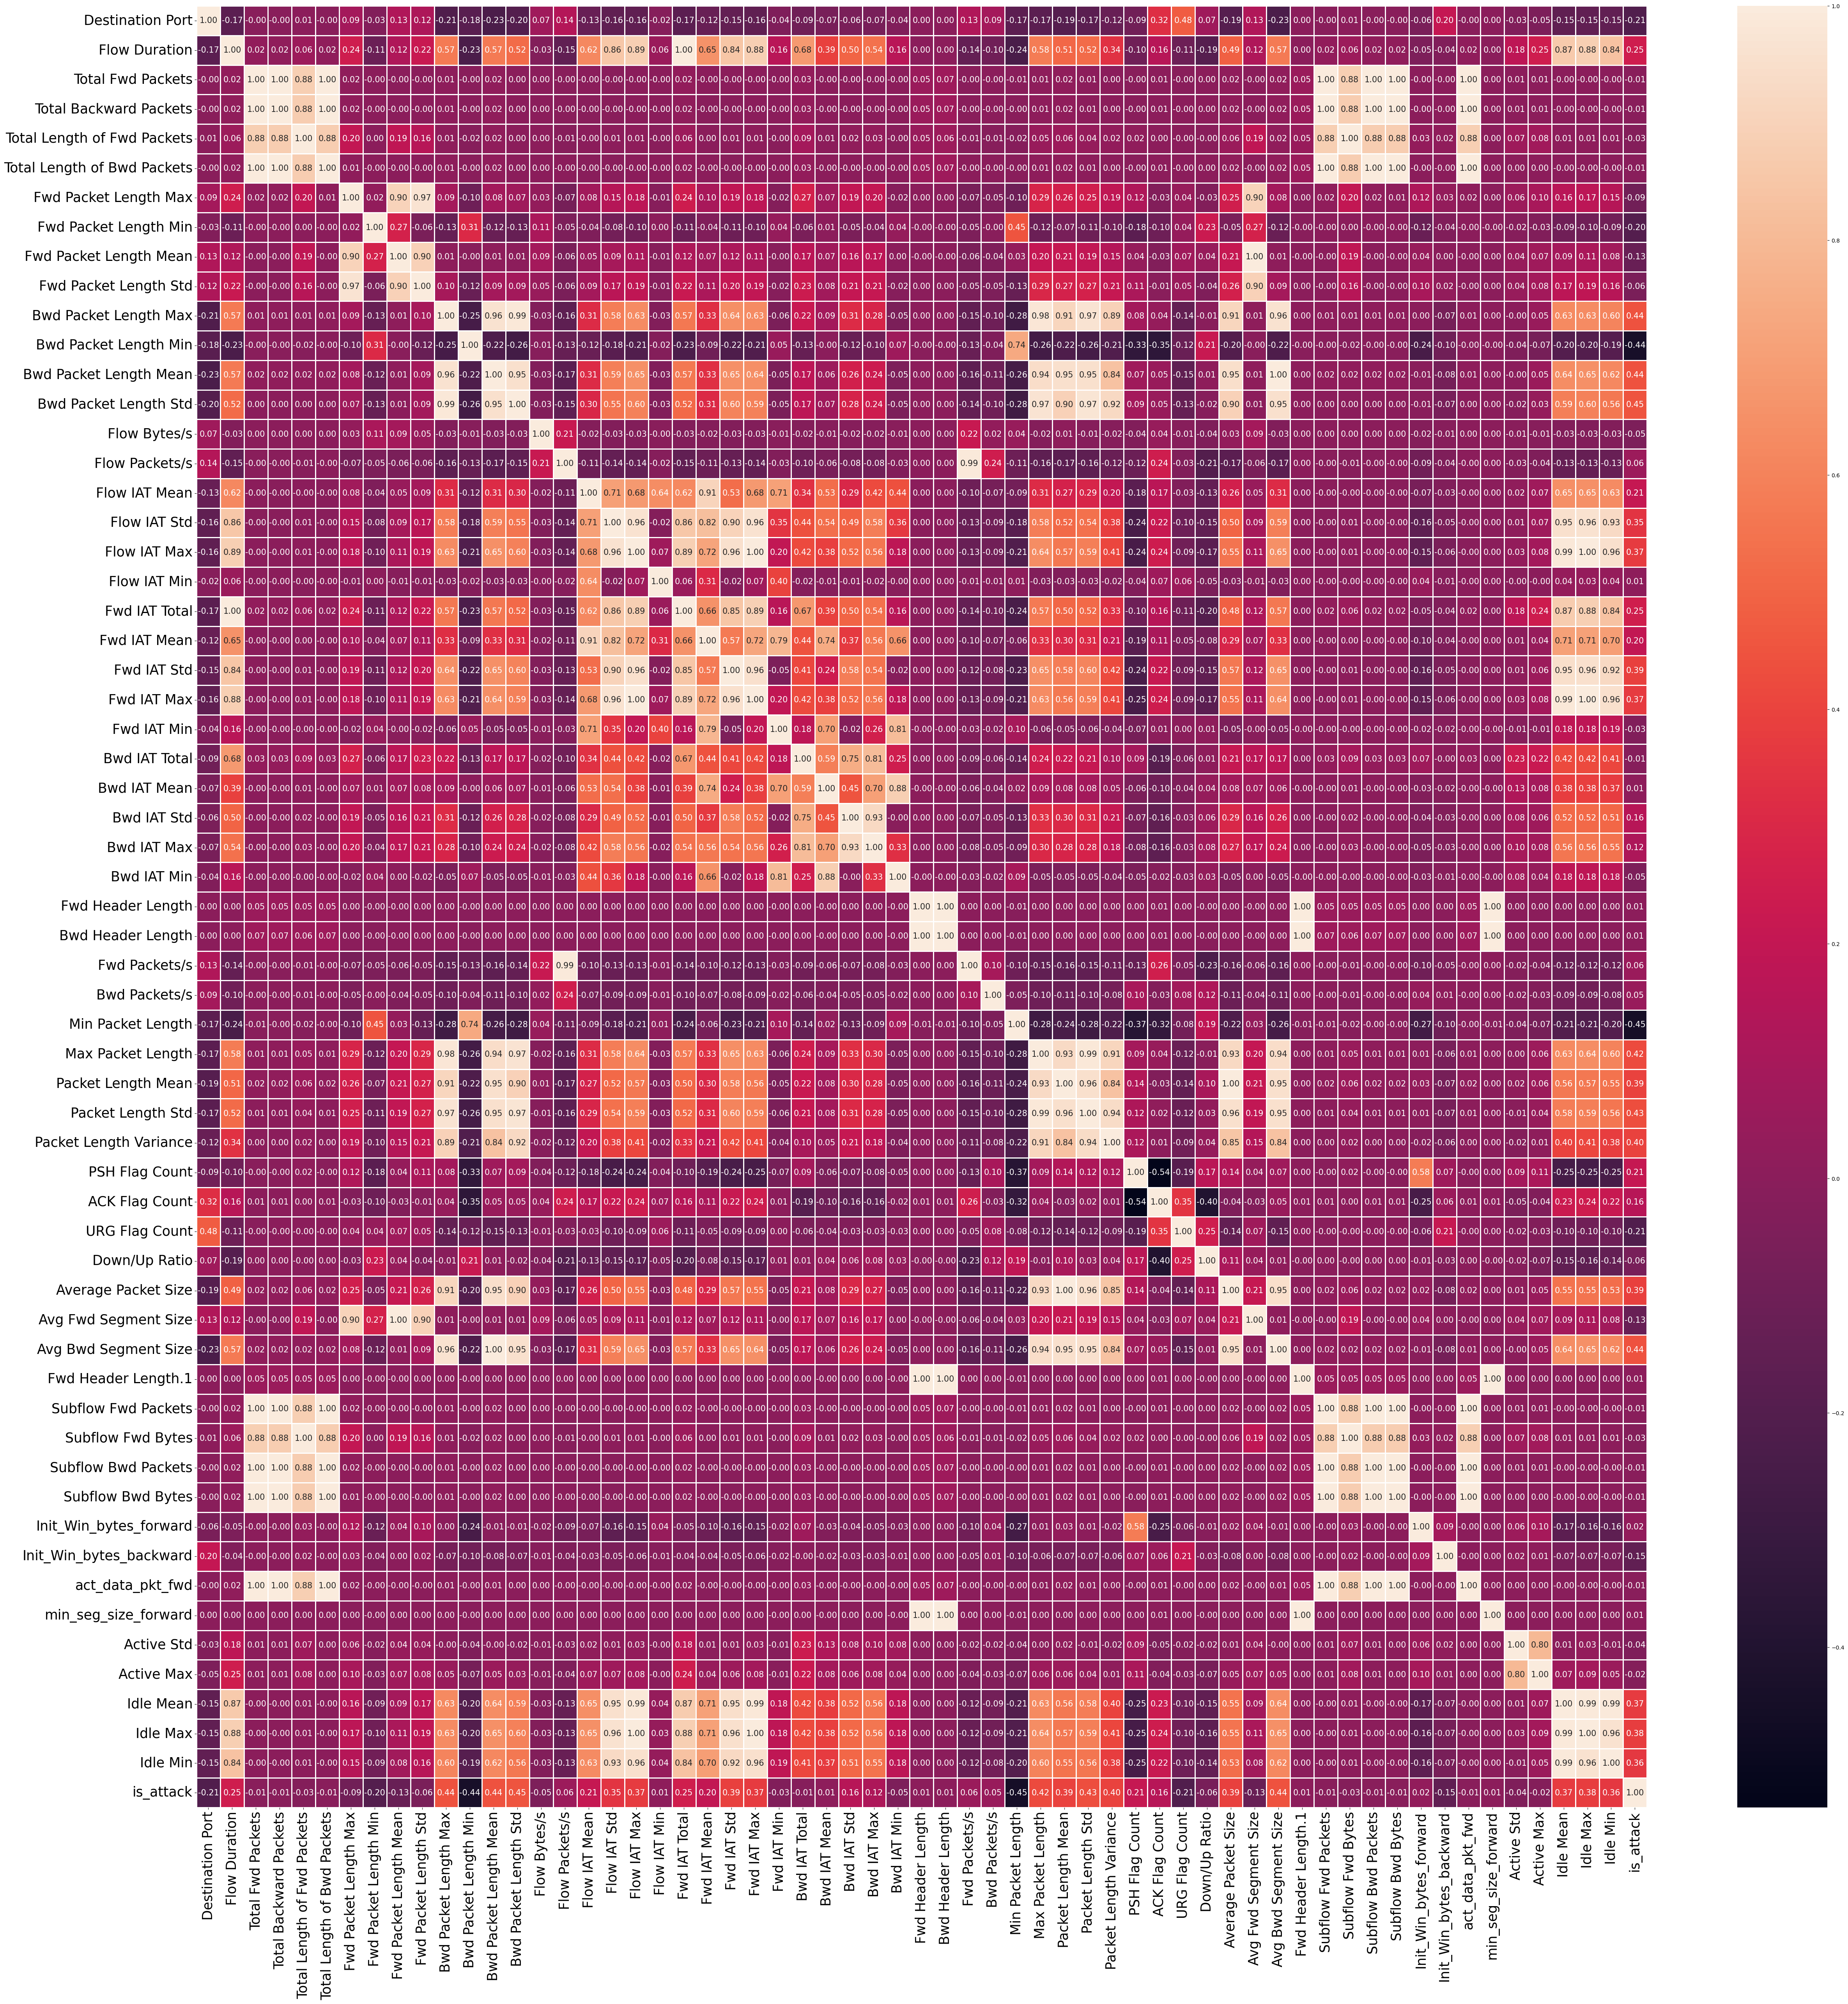

In [29]:
## plotting a correlation heatmap

plt.gcf().set_size_inches(60, 60)
hm = sns.heatmap(all_data_corr_mtrx, annot=True, linewidths=.8, annot_kws={"fontsize": 15}, fmt=".2f")
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 25)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 25)
#plt.savefig("corr_heatmap.png", dpi=200, format='png', bbox_inches = "tight", pad_inches=0.4)
plt.show()

In [30]:
## process correlation matrix, list highly correlated feature pairs
def srt_corr(mtrx):
    corr_ustack = mtrx.unstack().abs()
    #corr_ustack
    corr_srted = corr_ustack.sort_values(ascending=False)
    return corr_srted

srt_corr(all_data_corr_mtrx)

Destination Port        Destination Port          1.000000e+00
Fwd IAT Max             Fwd IAT Max               1.000000e+00
Flow IAT Std            Flow IAT Std              1.000000e+00
Flow IAT Max            Flow IAT Max              1.000000e+00
Flow IAT Min            Flow IAT Min              1.000000e+00
                                                      ...     
min_seg_size_forward    act_data_pkt_fwd          4.001474e-05
Fwd Packet Length Mean  min_seg_size_forward      8.717688e-07
min_seg_size_forward    Fwd Packet Length Mean    8.717688e-07
                        Avg Fwd Segment Size      8.717688e-07
Avg Fwd Segment Size    min_seg_size_forward      8.717688e-07
Length: 3721, dtype: float64

In [31]:
thres_corr = 0.95
epoch=0
highly_corr = {"dummy": "dummy"}
feats_deled = []

all_data_corr_mtrx2 = all_data_corr_mtrx.copy()  # for easy
def add_to_dct(l, ft, ft2):
    try:
        l[ft].append(ft2)
    except KeyError:
        l[ft] = [ft2]

get_imp = lambda feat: importances.loc[feat][0]
srt_key = lambda elem: get_imp(elem[0])  # gets imp of first elem

def what_to_del(dct_srt):
    to_del = []  #least imp feature
    for k, val in dct_srt.items():
        ## get all indexes lower than current k
        feats_lw_imp = importances[importances.index.slice_indexer(k)].index
        if set(val) - set(feats_lw_imp):  # feat k creates a corr pair w/ feature of higher importance --- delete feat k
            if k not in to_del: to_del.append(k)
        else:  # feat k creates a corr pair w/ features of lower importnace --- delete one w/ lowest imp
            for ft in feats_lw_imp[::-1]:  # searching from least important
                if ft in val and ft not in to_del:
                    to_del.append(ft)
                    break  ## deleting first founud feat of lowest possible importance
    return to_del


while highly_corr:
    count = 0
    highly_corr.clear()
    for feats, val in srt_corr(all_data_corr_mtrx2).items():
        if val > thres_corr and feats[0] != feats[1]:
            count += 1
            add_to_dct(highly_corr, feats[0], feats[1])
    if not highly_corr: break  # no more highly corr pairs
    highly_corr_srt = OrderedDict(sorted(highly_corr.items(), key=srt_key))  # sorted based on imp

    to_del = what_to_del(highly_corr_srt)
    feats_deled += to_del
    epoch +=1 # first epoch will be 1 not 0!
    print("there are {} higly correlated pairs in {} iteration".format(count, epoch))
    all_data_corr_mtrx2.drop(to_del, axis=1, inplace=True)
    all_data_corr_mtrx2.drop(to_del, axis=0, inplace=True)  # need to remove the feat from both cols and index

print("deleting: {} feature".format(len(feats_deled)))
print("finally deleted:\n"+ "\n".join(feats_deled))

there are 134 higly correlated pairs in 1 iteration
deleting: 27 feature
finally deleted:
Idle Max
Idle Min
Idle Mean
Flow IAT Max
Flow IAT Std
Fwd Packets/s
Fwd IAT Std
Fwd Packet Length Std
act_data_pkt_fwd
Total Fwd Packets
Subflow Bwd Packets
Flow Duration
min_seg_size_forward
Subflow Fwd Packets
Total Backward Packets
Subflow Bwd Bytes
Bwd Header Length
Subflow Fwd Bytes
Bwd Packet Length Max
Avg Fwd Segment Size
Fwd Header Length
Max Packet Length
Bwd Packet Length Mean
Packet Length Mean
Avg Bwd Segment Size
Bwd Packet Length Std
Packet Length Std


<ipython-input-31-b40aa34e52e7>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  get_imp = lambda feat: importances.loc[feat][0]


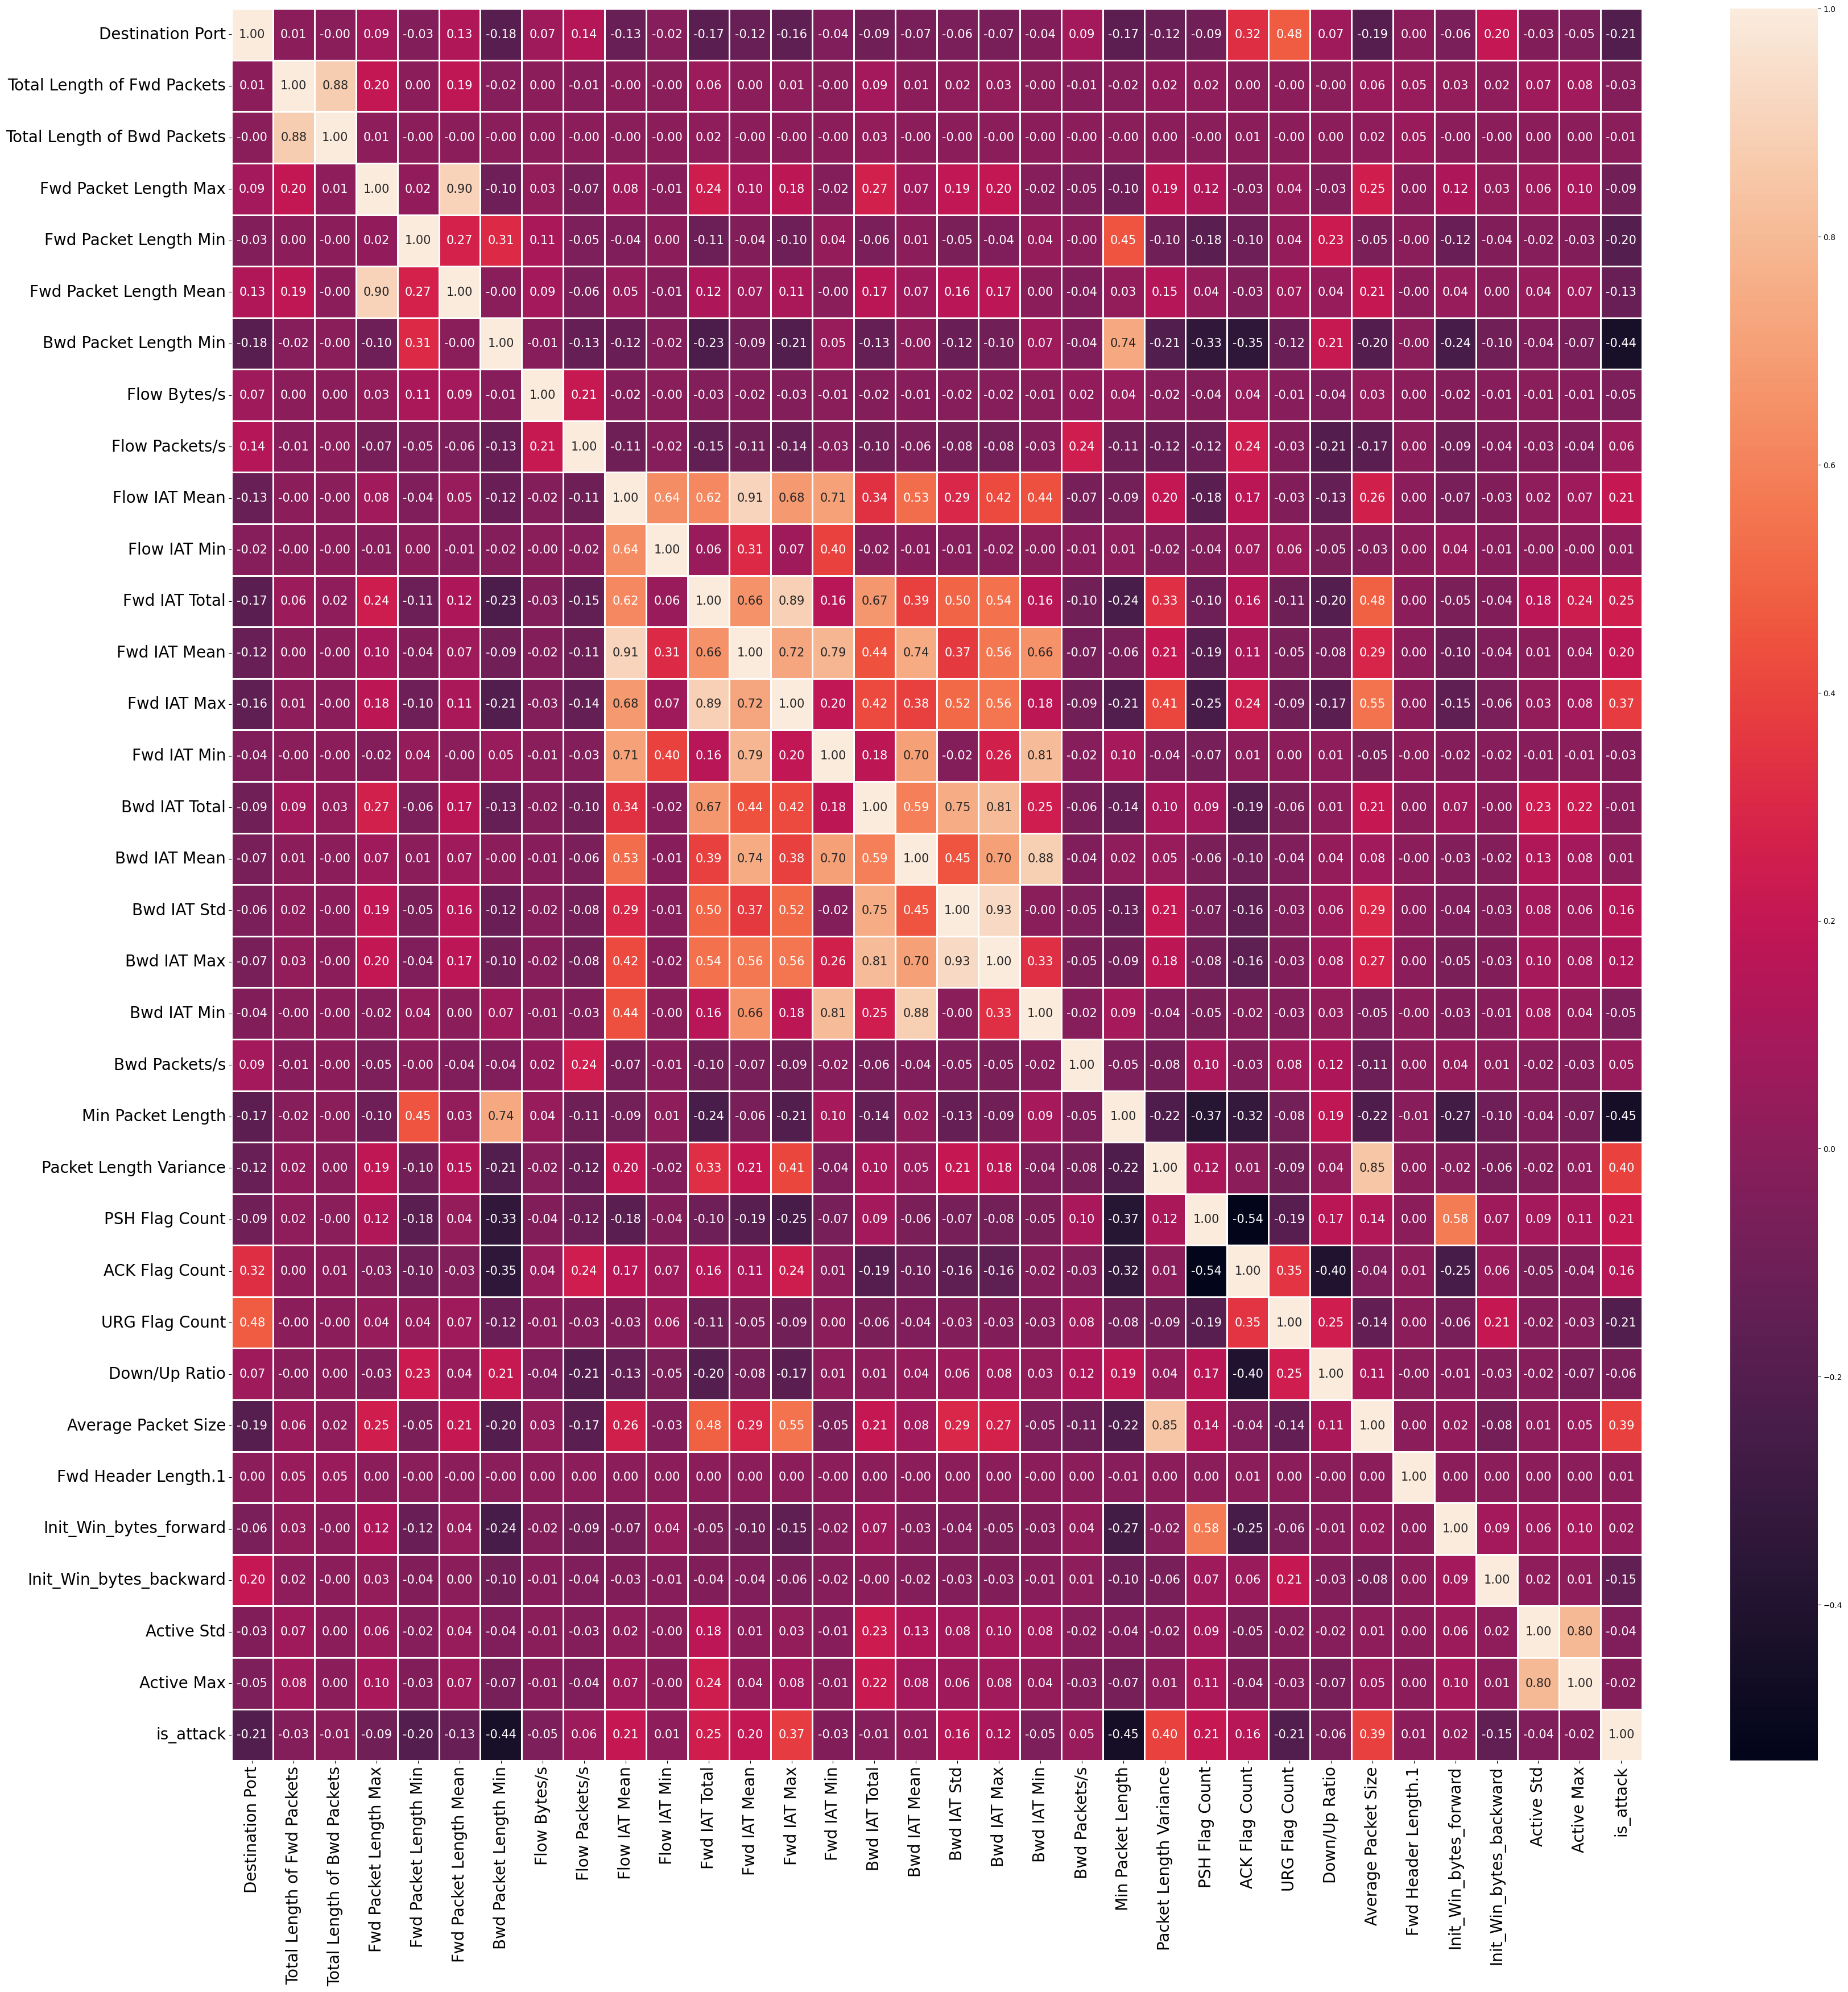

In [32]:
plt.gcf().set_size_inches(40, 40)
hm2 = sns.heatmap(all_data_corr_mtrx2, annot=True, linewidths=.8, annot_kws={"fontsize": 15}, fmt=".2f")
hm2.set_yticklabels(hm2.get_ymajorticklabels(), fontsize = 20)
hm2.set_xticklabels(hm2.get_xmajorticklabels(), fontsize = 20)
#plt.savefig("corr_heatmap2.png", dpi=200, format='png', bbox_inches = "tight", pad_inches=0.4)
plt.show()

In [33]:
DF = all_datav2.copy() ## just for ease of cells executing
DF.drop(feats_deled, axis=1, inplace=True)
all_datav3_cp = DF.copy()
DF # just check

Destination Port  Total Length of Fwd Packets  \
11564                80                          443   
38615                80                          195   
6991                 53                          167   
44163               443                         1106   
47255                53                           76   
...                 ...                          ...   
49972              2046                            0   
49975              1047                            2   
49976                80                           26   
49983                80                           12   
49995                80                          300   

       Total Length of Bwd Packets  Fwd Packet Length Max  \
11564                          872                    437   
38615                         1703                    195   
6991                           433                     64   
44163                          538                    821   
47255                          288                     38   
...                            ...                    ...   
49972                            6                      0   
49975                            6                      2   
49976                        11607                     20   
49983                            0                      6   
49995                        11595                    300   

       Fwd Packet Length Min  Fwd Packet Length Mean  Bwd Packet Length Min  \
11564                      0              147.666667                      0   
38615                      0               39.000000                      0   
6991                      43               55.666667                    118   
44163                      0              184.333333                      0   
47255                     38               38.000000                    144   
...                      ...                     ...                    ...   
49972                      0                0.000000                      6   
49975                      2                2.000000                      6   
49976                      0                8.666667                      0   
49983                      6                6.000000                      0   
49995                      0              100.000000                      0   

        Flow Bytes/s  Flow Packets/s  Flow IAT Mean  ...  ACK Flag Count  \
11564   16009.837223       85.223468   1.368950e+04  ...               0   
38615      31.575612        0.133090   8.587098e+06  ...               0   
6991        6.170278        0.061703   1.940000e+07  ...               0   
44163   18137.887660      154.458897   6.972231e+03  ...               0   
47255    5857.646320       64.369740   2.071367e+04  ...               0   
...              ...             ...            ...  ...             ...   
49972  125000.000000    41666.666670   4.800000e+01  ...               0   
49975  205128.205100    51282.051280   3.900000e+01  ...               0   
49976   19735.982670       11.875860   9.823850e+04  ...               0   
49983     749.437922      249.812640   5.337333e+03  ...               0   
49995  200532.730900      151.727161   7.414625e+03  ...               0   

       URG Flag Count  Down/Up Ratio  Average Packet Size  \
11564               0              1           187.857143   
38615               0              0           237.250000   
6991                0              1           110.666667   
44163               0              1           117.428571   
47255               0              1           100.500000   
...               ...            ...                  ...   
49972               0              1             3.000000   
49975               0              1             5.000000   
49976               0              1          1661.857143   
49983               0              1             4.500000   
49995               0              2          1321.666667   

      

In [34]:
DF.describe().T

count          mean           std  \
Destination Port             21486.0  6.257446e+03  1.592654e+04   
Total Length of Fwd Packets  21486.0  5.085767e+02  9.612191e+03   
Total Length of Bwd Packets  21486.0  3.504339e+04  4.170425e+06   
Fwd Packet Length Max        21486.0  1.805235e+02  6.339439e+02   
Fwd Packet Length Min        21486.0  1.324835e+01  5.252037e+01   
Fwd Packet Length Mean       21486.0  4.804123e+01  1.651881e+02   
Bwd Packet Length Min        21486.0  2.810081e+01  5.556936e+01   
Flow Bytes/s                 21486.0  1.062403e+06  1.725866e+07   
Flow Packets/s               21486.0  8.035869e+04  2.797745e+05   
Flow IAT Mean                21486.0  1.805016e+06  4.828313e+06   
Flow IAT Min                 21486.0  1.746788e+05  3.146504e+06   
Fwd IAT Total                21486.0  1.925441e+07  3.727786e+07   
Fwd IAT Mean                 21486.0  3.540314e+06  9.612105e+06   
Fwd IAT Max                  21486.0  1.540978e+07  3.247635e+07   
Fwd IAT Min                  21486.0  8.229948e+05  7.835078e+06   
Bwd IAT Total                21486.0  9.485118e+06  2.811307e+07   
Bwd IAT Mean                 21486.0  1.788342e+06  8.225031e+06   
Bwd IAT Std                  21486.0  2.167980e+06  8.296176e+06   
Bwd IAT Max                  21486.0  5.973232e+06  2.089154e+07   
Bwd IAT Min                  21486.0  7.179601e+05  7.208676e+06   
Bwd Packets/s                21486.0  7.819482e+03  4.198729e+04   
Min Packet Length            21486.0  1.154529e+01  2.143257e+01   
Packet Length Variance       21486.0  9.624642e+05  2.297352e+06   
PSH Flag Count               21486.0  3.439449e-01  4.750340e-01   
ACK Flag Count               21486.0  3.568370e-01  4.790773e-01   
URG Flag Count               21486.0  6.343666e-02  2.437524e-01   
Down/Up Ratio                21486.0  6.523318e-01  6.343264e-01   
Average Packet Size          21486.0  2.802354e+02  4.333041e+02   
Fwd Header Length.1          21486.0 -3.542399e+03  5.730595e+05   
Init_Win_bytes_forward       21486.0  7.006937e+03  1.341691e+04   
Init_Win_bytes_backward      21486.0  1.437765e+03  7.113866e+03   
Active Std                   21486.0  3.475982e+04  3.923999e+05   
Active Max                   21486.0  1.462367e+05  9.861843e+05   
is_attack                    21486.0  4.594620e-01  4.983656e-01   

                                      min         25%           50%  \
Destination Port             0.000000e+00   80.000000     80.000000   
Total Length of Fwd Packets  0.000000e+00    2.000000     51.000000   
Total Length of Bwd Packets  0.000000e+00    0.000000    112.000000   
Fwd Packet Length Max        0.000000e+00    2.000000     31.000000   
Fwd Packet Length Min        0.000000e+00    0.000000      0.000000   
Fwd Packet Length Mean       0.000000e+00    2.000000     26.500000   
Bwd Packet Length Min        0.000000e+00    0.000000      0.000000   
Flow Bytes/s                 0.000000e+00  118.877594   3431.226560   
Flow Packets/s               1.672181e-02    1.026874     94.696053   
Flow IAT Mean                5.000000e-01   60.000000  13041.083333   
Flow IAT Min                -1.300000e+01    3.000000      4.000000   
Fwd IAT Total                0.000000e+00    0.000000     70.000000   
Fwd IAT Mean                 0.000000e+00    0.000000     62.000000   
Fwd IAT Max                  0.000000e+00    0.000000     67.000000   
Fwd IAT Min                 -1.000000e+00    0.000000      3.000000   
Bwd IAT Total                0.000000e+00    0.000000      3.000000   
Bwd IAT Mean                 0.000000e+00    0.000000      3.000000   
Bwd IAT Std                  0.000000e+00    0.000000      0.000000   
Bwd IAT Max                  0.000000e+00    0.000000      3.000000   
Bwd IAT Min                  0.000000e+00    0.000000      1.000000   
Bwd Packets/s                0.000000e+00    0.060944      9.396581   
Min Packet Length            0.000000e+00    0.000000      0.000000   
Packet Length Var

## Estandarization of data

In [35]:
'''
Age_Category = df['Age_Category']
snss.set_theme(style="darkgrid")
plts.figure(figsize = (10,10))
snss.histplot(data = df, x = Age_Category ,kde = True, bins = 40 ,  color = 'b')
plts.title('Age Category Distribution')
plts.show()


info = DF["Destination Port"].value_counts()
sns.set_theme(style="darkgrid")
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
#ax3 = fig.add_subplot(1,3,3)
ax1.set_title("Destination port")
ax1.hist(info)
ax2 = fig.add_subplot(1,3,2)
sns.histplot(data=DF, x= DF["Destination Port"],kde = True, bins = 200 ,  color = 'b')
plt.show()

#info
'''

'\nAge_Category = df[\'Age_Category\']\nsnss.set_theme(style="darkgrid")\nplts.figure(figsize = (10,10))\nsnss.histplot(data = df, x = Age_Category ,kde = True, bins = 40 ,  color = \'b\')\nplts.title(\'Age Category Distribution\')\nplts.show()\n\n\ninfo = DF["Destination Port"].value_counts()\nsns.set_theme(style="darkgrid")\nfig = plt.figure(figsize=(15,5))\nax1 = fig.add_subplot(1,3,1)\n#ax3 = fig.add_subplot(1,3,3)\nax1.set_title("Destination port")\nax1.hist(info)\nax2 = fig.add_subplot(1,3,2)\nsns.histplot(data=DF, x= DF["Destination Port"],kde = True, bins = 200 ,  color = \'b\')\nplt.show()\n\n#info\n'

In [36]:
train_set, val_set, test_set = train_val_test_split(DF)
x_train= train_set.drop(columns=['is_attack'] ).copy()
y_train= train_set['is_attack'].copy()

x_val= val_set.drop(columns=['is_attack'] ).copy()
y_val= val_set['is_attack'].copy()

x_test= test_set.drop(columns=['is_attack'] ).copy()
y_test= test_set['is_attack'].copy()


Transforming data using a robust scaler

In [37]:
robust_scaler = RobustScaler()
x_train_tr = robust_scaler.fit_transform(x_train)
x_val_tr = robust_scaler.transform(x_val)
x_test_tr = robust_scaler.transform(x_test)

# TRAINING MODELS

## LOGISTIC REGRESSION

In [38]:
clf = LogisticRegression(random_state=0, max_iter=5000,solver="newton-cg",)
clf.fit(x_train_tr, y_train)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


LogisticRegression(max_iter=5000, random_state=0, solver='newton-cg')

### validating model

In [39]:
y_pred = clf.predict(x_val_tr)

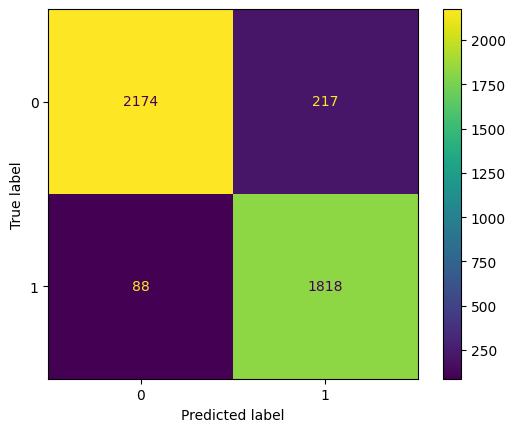

In [40]:
ConfusionMatrixDisplay.from_estimator(clf, x_val_tr, y_val, values_format='d')

In [41]:
f1_score(y_val, y_pred)

0.9226084750063436

### Testing model

In [42]:
y_pred = clf.predict(x_test_tr)

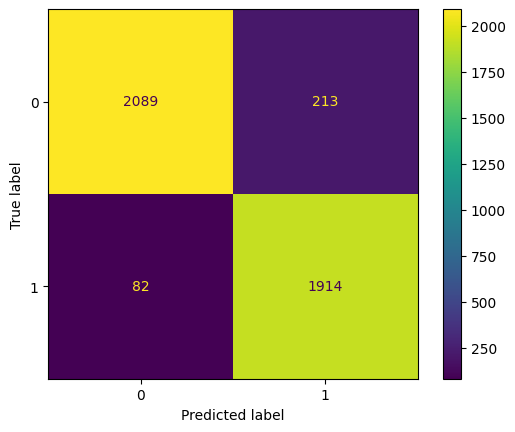

In [43]:
ConfusionMatrixDisplay.from_estimator(clf, x_test_tr, y_test, values_format='d')

In [44]:
F1_LR = f1_score(y_test, y_pred)
F1_LR

0.928450157652195

## SUPPORT VECTOR MACHINE

In [45]:
svm_clf = SVC(kernel="rbf", C=50)
svm_clf.fit(x_train_tr, y_train)

SVC(C=50)

### validating

In [46]:
y_pred = svm_clf.predict(x_val_tr)

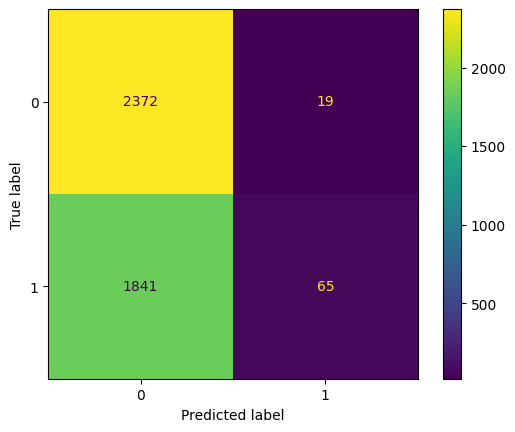

In [47]:
ConfusionMatrixDisplay.from_estimator(svm_clf, x_val_tr, y_val, values_format='d')

In [48]:
f1_score(y_val, y_pred)

0.06532663316582915

### testing

In [49]:
y_pred = svm_clf.predict(x_test_tr)

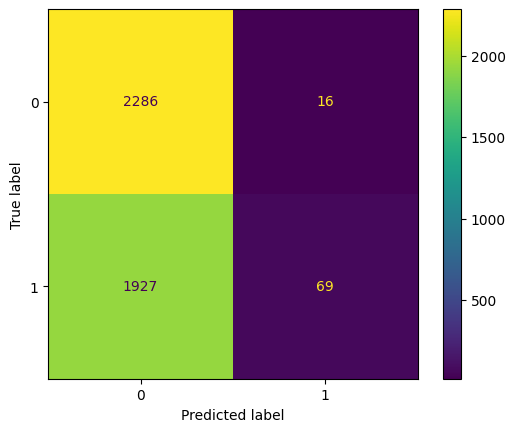

In [50]:
ConfusionMatrixDisplay.from_estimator(svm_clf, x_test_tr, y_test, values_format='d')

In [51]:
F1_SVM = f1_score(y_test, y_pred)
F1_SVM

0.06631427198462278

## DECISION TREE

In [52]:
dtre_clf = DecisionTreeClassifier()
dtre_clf.fit(x_train_tr, y_train)

DecisionTreeClassifier()

### validating

In [53]:
y_pred = dtre_clf.predict(x_val_tr)

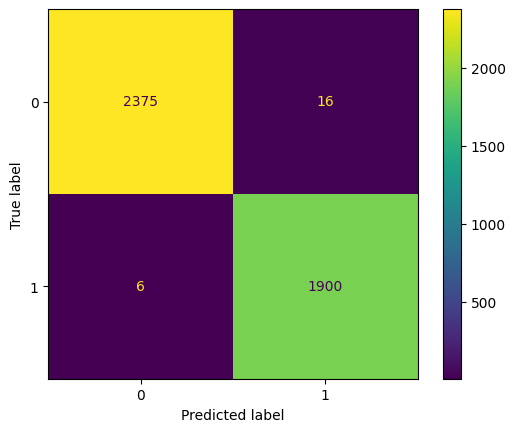

In [54]:
ConfusionMatrixDisplay.from_estimator(dtre_clf, x_val_tr, y_val, values_format='d')

In [55]:
f1_score(y_val, y_pred)

0.9942438513867086

### Testing model

In [56]:
y_pred = dtre_clf.predict(x_test_tr)

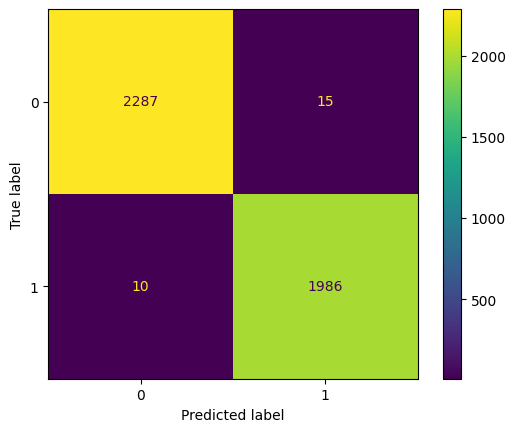

In [57]:
ConfusionMatrixDisplay.from_estimator(dtre_clf, x_test_tr, y_test, values_format='d')

In [58]:
F1_DT = f1_score(y_test, y_pred)
F1_DT

0.9937453089817363

## RANDOM FOREST

In [59]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
rf_clf.fit(x_train_tr, y_train)

RandomForestClassifier(random_state=0)

### Validating model

In [60]:
y_pred = rf_clf.predict(x_val_tr)

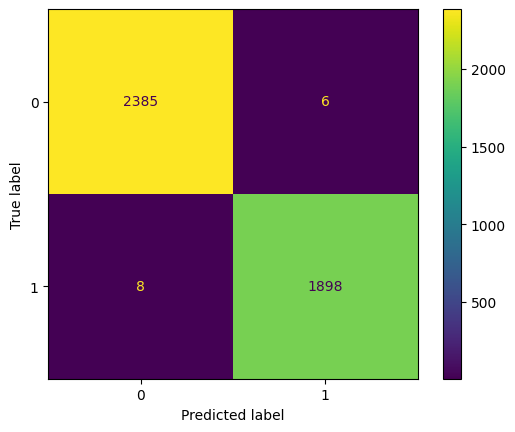

In [61]:
ConfusionMatrixDisplay.from_estimator(rf_clf, x_val_tr, y_val, values_format='d')

In [62]:
f1_score(y_val, y_pred)


0.9963254593175853

### Testing

In [63]:
y_pred =rf_clf.predict(x_test_tr)

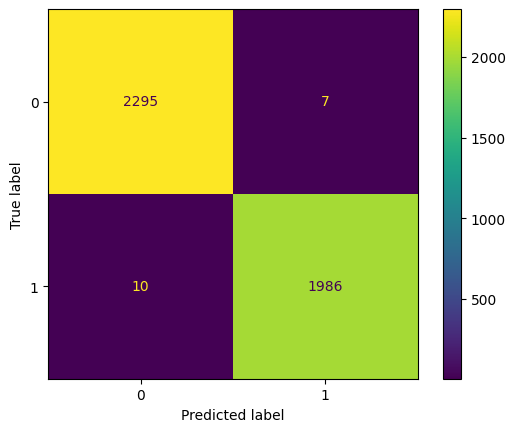

In [64]:
ConfusionMatrixDisplay.from_estimator(rf_clf, x_test_tr, y_test, values_format='d')

In [65]:
RF_LR = f1_score(y_test, y_pred)
RF_LR

0.9957382802707445

## KNN

In [66]:
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(x_train_tr, y_train)

KNeighborsClassifier()

### Validating model

In [67]:
y_pred = knn_clf.predict(x_val_tr)

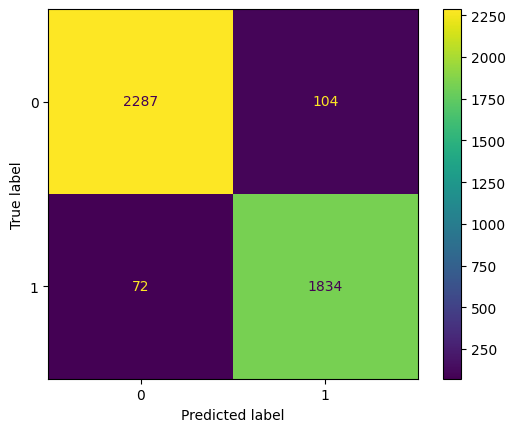

In [68]:
ConfusionMatrixDisplay.from_estimator(knn_clf, x_val_tr, y_val, values_format='d')

In [69]:
f1_score(y_val, y_pred)

0.9542143600416233

### testin model

In [70]:
y_pred=knn_clf.predict(x_test_tr)

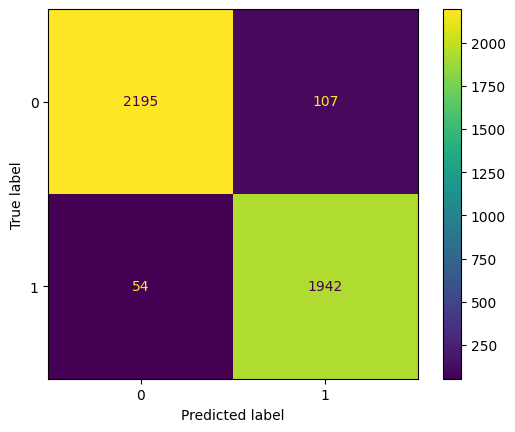

In [71]:
ConfusionMatrixDisplay.from_estimator(knn_clf, x_test_tr, y_test, values_format='d')

In [72]:
F1_KNN = f1_score(y_test, y_pred)
F1_KNN

0.9601977750309023

# MLP

##  Defining Early Stopping, Learning Rate Sceduler, Class_weights callbacks


In [73]:

# Define Early Stopping callback to monitor validation loss
early_stopping = EarlyStopping(
    monitor='val_accuracy',    # Monitor validation accuracy
    patience=10,               # Stop training after 5 epochs with no improvement
    verbose=1,                 # Provide verbose output when early stopping is triggered
    restore_best_weights=True) # Restore model weights with best validation loss

# Define ReduceLROnPlateau scheduler, LR:Learning Rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',    # Monitor validation accuracy
    patience= 5,               # Default value for patience is 10
    min_lr=1e-07,              # min_lr: Minimum learning rate (deafault value=0.0001)
    verbose=1,                 # verbose = 1: update messages
    factor=0.1)                # The default factor is 0.1, which reduces
                               # the learning rate by 10% when triggered.

""" Additional parameter for reduce_lr"""
""" cooldown: Integer. Number of epochs to wait before resuming normal operation
after the learning rate has been reduced. """

# Calculate class weights using balanced weighting
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
# Convert class weights array to a dictionary with class indices as keys
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [74]:
print (x_train_tr.shape[1])

33


In [75]:
input_shape = x_train_tr.shape[1]

# Simple model
model_1 = Sequential([
    Input(shape=(input_shape,)),
    Dense(8, activation='sigmoid'),
    Dense(4,  activation='relu'),
    Dense(2,  activation='relu'),
    Dense(1,  activation='sigmoid')
])

In [76]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 8)                   │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 321 (1.25 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(0.1),
    loss='binary_crossentropy', metrics=['accuracy']
)

In [78]:
H = model_1.fit(x_train_tr, y_train,
                validation_data=(x_val_tr, y_val),
                epochs=300,
                verbose=False,
                batch_size=1024)

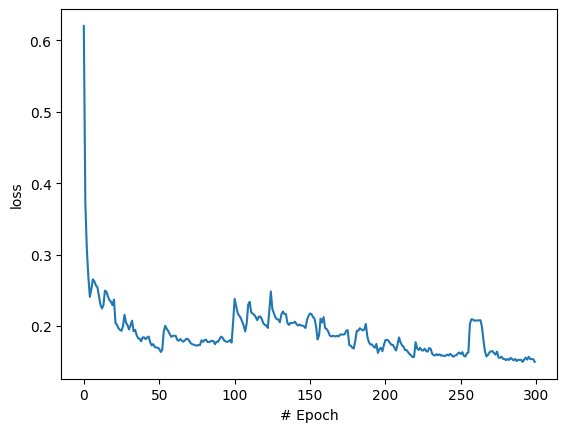

In [79]:
plt.xlabel("# Epoch")
plt.ylabel("loss")
plt.plot(H.history["loss"])

In [80]:
model_2 = Sequential([
    Input(shape=(input_shape,)),
    Dense(128, activation='tanh'),
    Dense(64,  activation='selu'),
    Dense(32,  activation='selu'),
    Dense(16,  activation='selu'),
    Dense(8,   activation='selu'),
    Dense(4,   activation='selu'),
    Dense(2,   activation='selu'),
    Dense(1,   activation='sigmoid')
])

In [81]:
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 128)                 │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 2)                   │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,401 (60.16 KB)

 Trainable params: 15,401 (60.16 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(0.1),
    loss='binary_crossentropy', metrics=['accuracy']
)

In [83]:
H2 = model_2.fit(x_train_tr, y_train,
                validation_data=(x_val_tr, y_val),
                epochs=300,
                verbose=False,
                batch_size=1024)

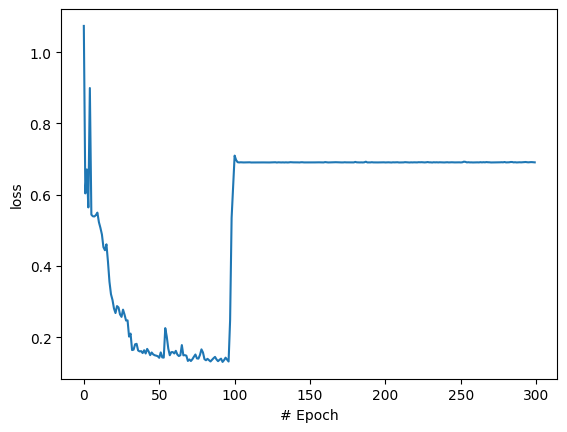

In [84]:
plt.xlabel("# Epoch")
plt.ylabel("loss")
plt.plot(H2.history["loss"])

In [85]:
y_pred = model_1.predict(x_test_tr)

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [86]:
y_pred_labels = (y_pred > 0.5).astype(int)
y_pred_labels

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [87]:
DL1_F1 = f1_score(y_test, y_pred_labels)
DL1_F1

0.9444168734491315

In [88]:
y_pred = model_2.predict(x_test_tr)

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [89]:
y_pred_labels = (y_pred > 0.5).astype(int)

In [90]:
DL2_F1 = f1_score(y_test, y_pred_labels)
DL2_F1

0.0

In [91]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 216.4680619239807 seconds ---
